In [1]:
### YOU MIGHT NOT NEED THIS LINE OR REPLACE IT BY YOUR WORKING DIRECTORY
%cd /g/data/gb32/thanhson/DEEP_LEARNING/MTI/Pub

%config InlineBackend.figure_format = "retina"
%matplotlib inline

%load_ext autoreload
%autoreload 2

import tensorflow as tf
import numpy as np
from obspy import read, read_inventory, read_events, Stream, Trace
import glob
import matplotlib.pyplot as plt
from netCDF4 import Dataset
from pathlib import Path
from obspy.imaging.mopad_wrapper import beach
import pickle

from matplotlib import rcParams
rcParams["savefig.dpi"] = 300
rcParams["figure.dpi"] = 300
rcParams["font.size"] = 8

/g/data/gb32/thanhson/DEEP_LEARNING/MTI/Pub


## Hyperparameters

In [2]:
data_path = Path('.')
evname = '19971122172035'

## Data
station_fname = data_path/evname/'stations.xml'
waveform_fname = data_path/evname/'waveforms.mseed'
event_fname=data_path/evname/'event.xml'
config_fname=data_path/evname/'config.txt'

## Earth model
model_fname = data_path/'SoCal.plain.txt'
modname = model_fname.name.split('.')[0]

## Parameter for data processing
## time window
filter_params={'freqmin':0.02, 'freqmax':0.05, 'corners':4, 'zerophase':False}
window_params={'t0':0, 'vred':0, 'window':250}

## sampling interval in second
delta = 1

## Preparation

In [3]:
from UTIL import prepare_stats

## read event info from file
ev = read_events(event_fname)[0]
## prepare object instance for all stations listed in the config file
allstats = prepare_stats(ev, config_fname, window_params)

In [4]:
from CPS import update_with_Gtensors

## calculate Green's tensor for all station
vmodel = np.loadtxt(model_fname).T
update_with_Gtensors(allstats,vmodel,filter_params,delta,rootdir='GREENS')

In [5]:
from UTIL import update_with_obsdata

ok_stats = update_with_obsdata(allstats,station_fname,waveform_fname,filter_params,delta)

## Inversion and visualization of result

In [6]:
from MT import invert_for_mt_and_timeshift
## running inversion and record history output
history = invert_for_mt_and_timeshift(ok_stats, random_seed=1)

2023-07-17 14:52:38.236163: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-07-17 14:52:38.236219: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-bdw-0015.gadi.nci.org.au): /proc/driver/nvidia/version does not exist


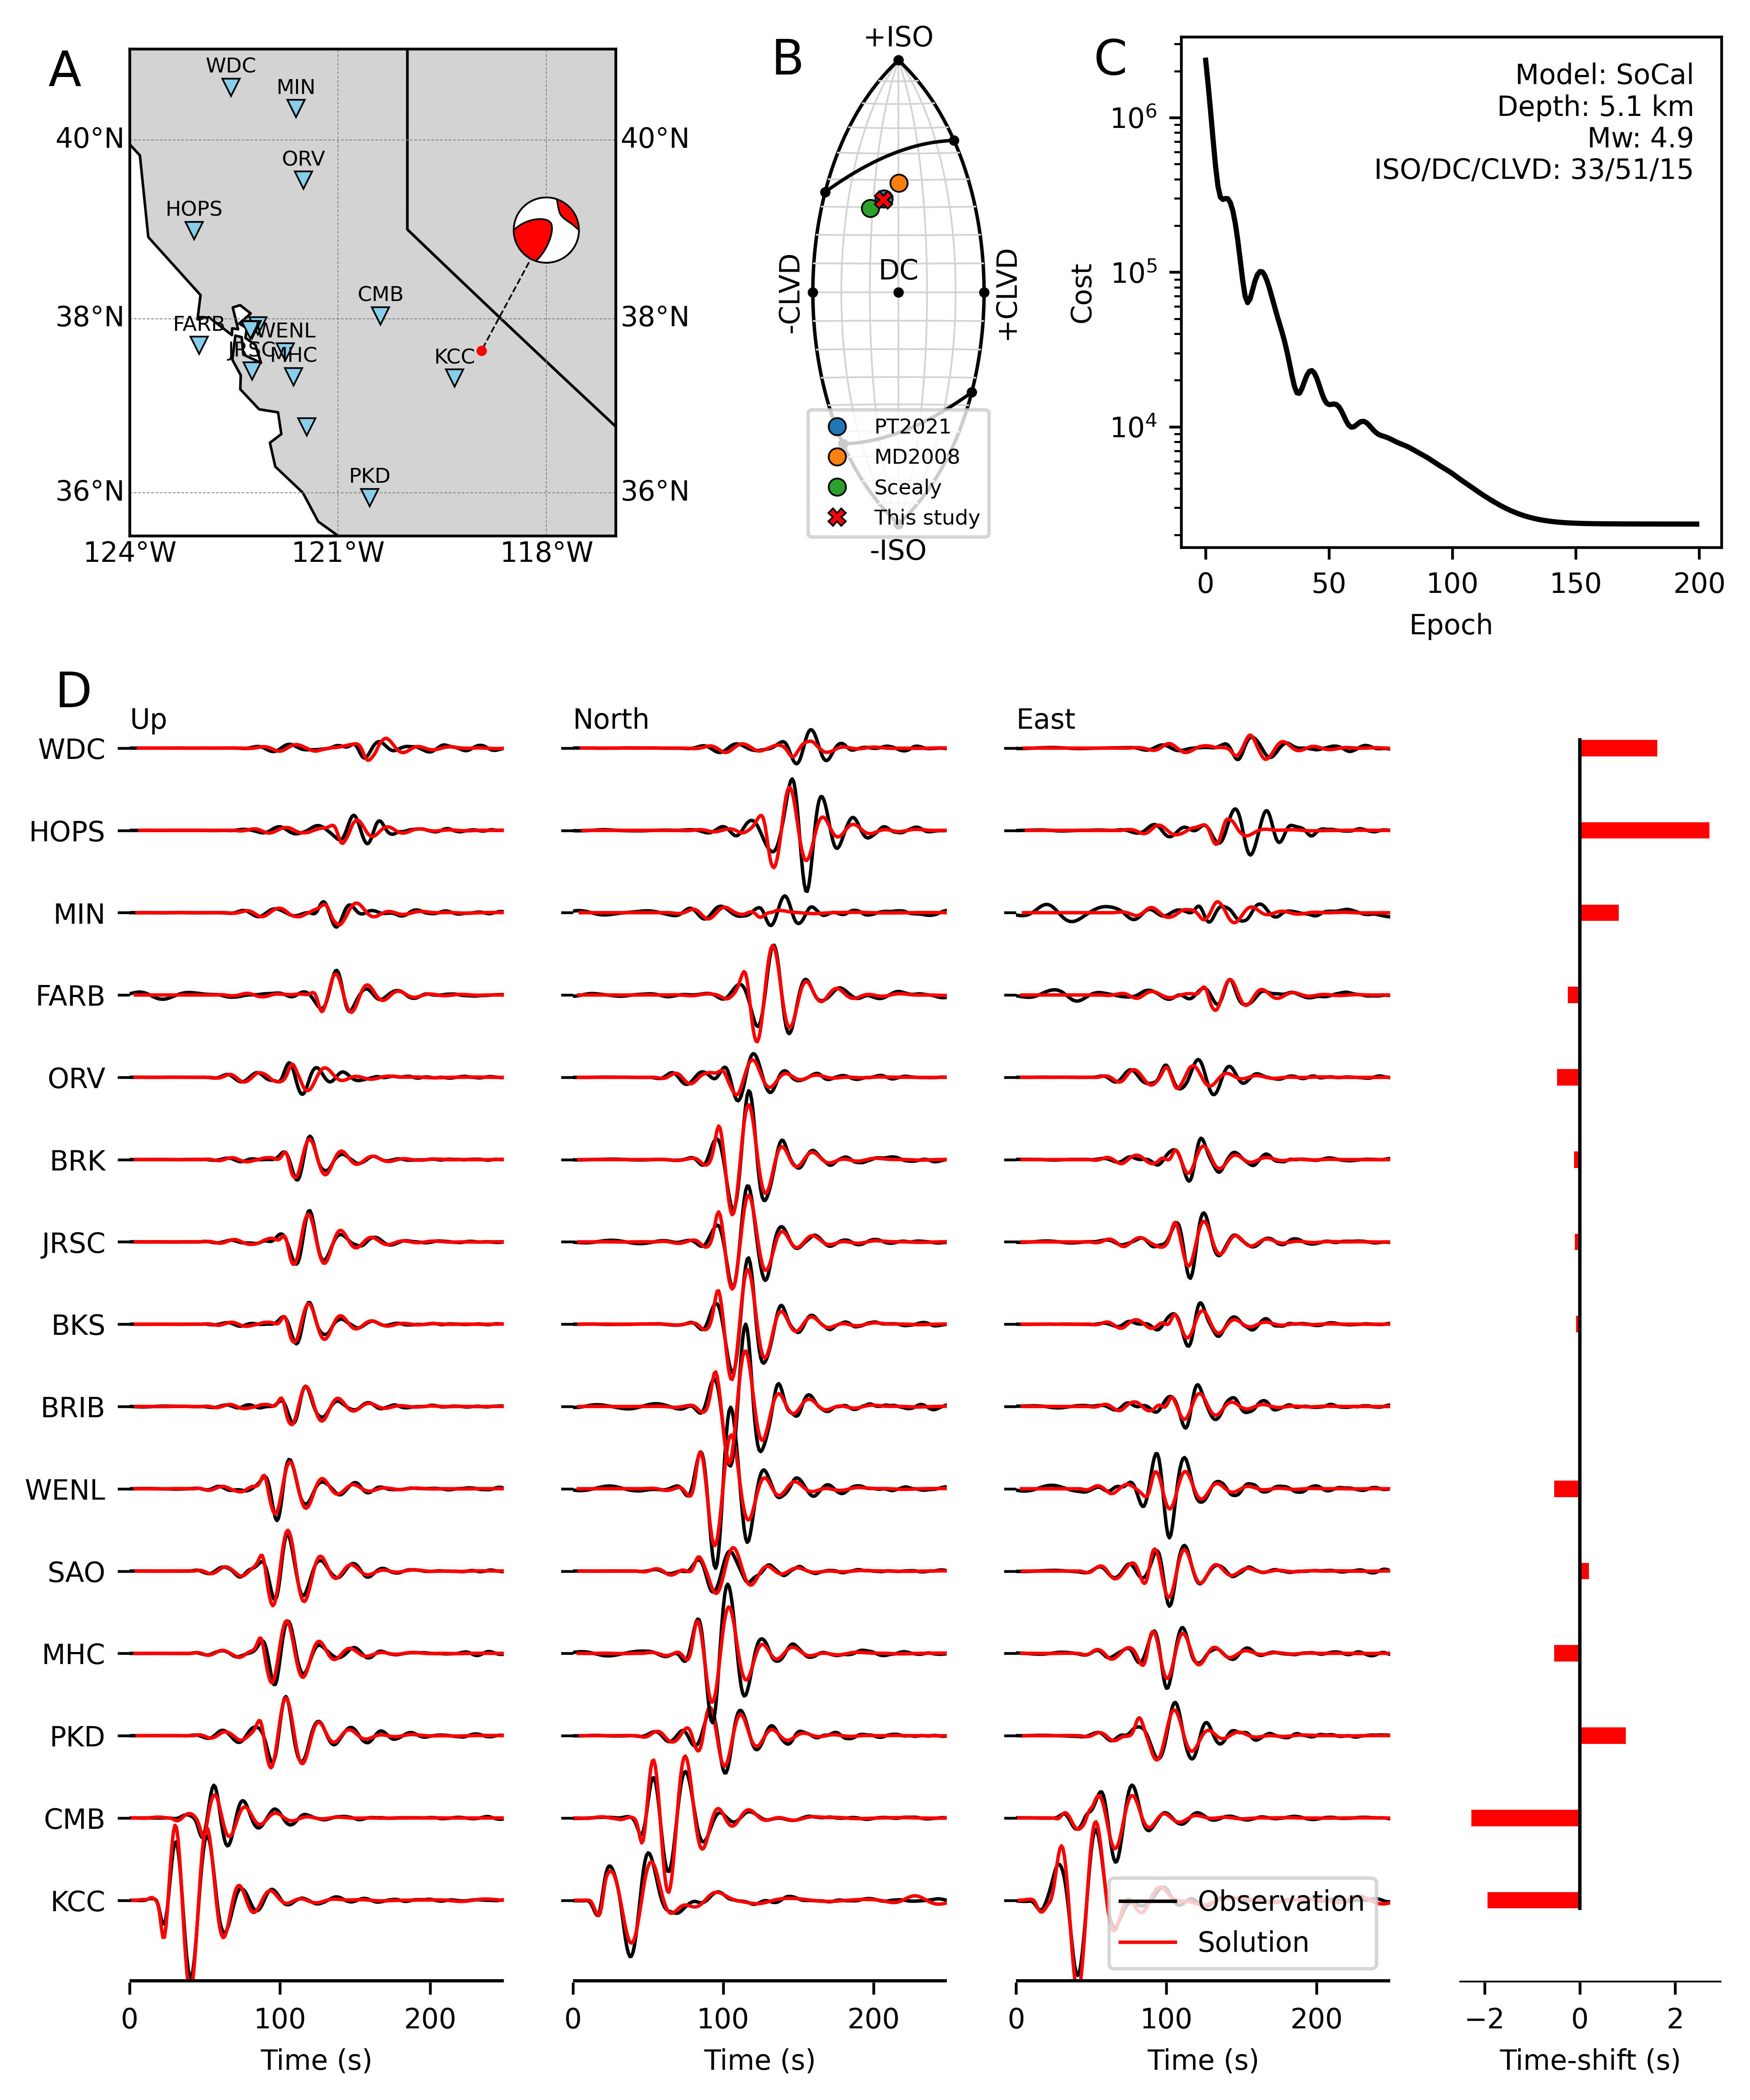

In [7]:
from UTIL import plot_summary

previous_solutions = {'PT2021': [ 1.53859001e+15,  1.21414120e+16,  2.44810916e+16,  1.32490727e+16, -1.50308373e+15, -1.61516658e+16], 
                     'MD2008': [ 3.2230e+15,  1.4432e+16,  2.8164e+16,  1.3659e+16,  3.3700e+14, -1.4049e+16],
                     'Scealy': [2.0380, 12.2270, 15.2840, 12.1490, -2.5666, -15.7750]}

plot_summary(history, modname, previous_solutions=previous_solutions)
plt.savefig(data_path/evname/'LV2_Summary.pdf')